# Acredius AG


## Part 1: Descriptive analysis

In [45]:
import pandas as pd 
import  numpy as np
from  unidecode import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import  train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import mean_absolute_error


In [2]:
data= pd.read_excel('ATUCE_-_Data_Scientist_-_Case_study_data_2021_03.xlsx')

# rename columns 
data.columns = data.columns.str.replace("'", "")
data.columns = data.columns.str.replace(" ", "_")
df=data

In [3]:
#change evry colum contien - by nan 
df.replace(to_replace='-', value='nan',inplace=True) 
df.replace(to_replace='N/A', value='nan',inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688 entries, 0 to 687
Data columns (total 87 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   ID                                      688 non-null    int64  
 1   Pays                                    688 non-null    object 
 2   Taux                                    688 non-null    object 
 3   Mois                                    688 non-null    int64  
 4   Montant                                 688 non-null    object 
 5   Niveau_de_risque                        688 non-null    object 
 6   Emprunteur                              688 non-null    object 
 7   capital_social                          688 non-null    object 
 8   année_de_création                       688 non-null    int64  
 9   Antériorité                             688 non-null    object 
 10  effectifs                               687 non-null    object

In [5]:

nan_values = df.isnull().sum()
pourcentage= pd.DataFrame((np.array(nan_values)/688)*100 ,index=nan_values.index)
pourcentage

,0
ID,0.000000
Pays,0.000000
Taux,0.000000
Mois,0.000000
Montant,0.000000
...,...
Dettes_Nettes_/_Fonds_propres_18,81.686047
BFRE_en_nombre_de_jours_de_CA_15,72.965116
BFRE_en_nombre_de_jours_de_CA_16,63.953488
BFRE_en_nombre_de_jours_de_CA_17,72.674419


In [6]:
#drop all redundant and forward-looking columns

df =df.loc[:,['Pays', 'Taux', 'Mois', 'Montant', 'Niveau_de_risque',
       'Emprunteur', 'capital_social', 'année_de_création', 'Antériorité',
       'effectifs']]

In [7]:
for name in ['Pays','Taux','capital_social','Montant','effectifs']:
    try:
        df[name]= df[name].apply(lambda x : str(x).replace('€','').strip())
        df[name]= df[name].apply(lambda x : str(x).replace('%','').strip())
        df[name]= df[name].apply(lambda x : str(x).replace(',','.').strip())
        df[name]= df[name].apply(lambda x : str(x).replace(' ','').strip())
        df[name]= df[name].apply(lambda x : str(x).replace('Plusde','').strip())
        df[name]= df[name].apply(lambda x : str(x).replace('\n','').strip())
        df[name]= df[name].apply(lambda x : str(x).replace('-','').strip())        
    except :
        -1


In [13]:
#calculate the moyenne of range
def change_rang_to_num(df,lis,sep):
    for colum in lis :
        for i in range(len(df[colum])):
            try:
                if sep in df[colum][i] :
                    x= float(df[colum][i].split(sep)[0].strip())
                    y= float(df[colum][i].split(sep)[1].strip())
                    df[colum][i]=float((x+y)//2)
            except:
                -1

    return df
           
df =change_rang_to_num(df,['effectifs'],'à')

In [14]:
# calculate the moyenne of range
for name in ['Taux','capital_social','Montant','capital_social', 'année_de_création', 'Antériorité', 'effectifs']:
    try:
        df[name]= df[name].apply(lambda x: (unidecode(x).replace(' ',''))).astype(float)
    except :
        -1

In [15]:
df['Antériorité']= df['Antériorité'].apply(lambda x : str(x)[0:4])
df['Antériorité']= pd.to_numeric(df['Antériorité'])

df['capital_social']= df['capital_social'].replace(1, df['capital_social'].mean())
df['capital_social'].fillna((df['capital_social'].mean()), inplace=True)

df['effectifs']= df['effectifs'].apply(lambda x: (unidecode(str(x)).replace(' ',''))).astype(float)
df['effectifs'].fillna((df['effectifs'].mean()), inplace=True)


In [16]:
df.head()

,Pays,Taux,Mois,Montant,Niveau_de_risque,Emprunteur,capital_social,année_de_création,Antériorité,effectifs
0,France,5.85,48,1100000.0,B,Ets Provost Frères,3058500.0,1962,1991,30.500000
1,Espagne,5.50,48,310000.0,B+,INTERNATIONAL STUDIES SA,396072.0,1985,1998,30.500000
2,PaysBas,6.45,48,165000.0,B,Docufiller Sales,900.0,2016,2016,5.500000
3,France,0.06,60,2000000.0,B,E.B.P.,10000.0,2016,2014,150.500000
4,Italie,4.90,36,100000.0,B+,Deltagamma,10000.0,2003,2003,84.482379


In [17]:
# get correlation matrix 
corrolation=df.corr()
corrolation

,Taux,Mois,Montant,capital_social,année_de_création,Antériorité,effectifs
Taux,1.000000,0.009747,0.001764,-0.055398,0.049239,0.068014,-0.111758
Mois,0.009747,1.000000,0.145305,-0.112451,0.126728,0.199459,-0.098116
Montant,0.001764,0.145305,1.000000,-0.039789,-0.200151,-0.205086,0.253171
capital_social,-0.055398,-0.112451,-0.039789,1.000000,-0.106618,-0.133856,0.412743
année_de_création,0.049239,0.126728,-0.200151,-0.106618,1.000000,0.555382,-0.202236
Antériorité,0.068014,0.199459,-0.205086,-0.133856,0.555382,1.000000,-0.244499
effectifs,-0.111758,-0.098116,0.253171,0.412743,-0.202236,-0.244499,1.000000


<AxesSubplot:>

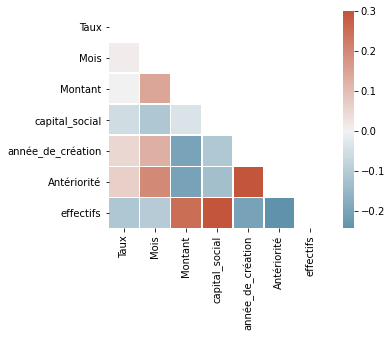

In [20]:
mask = np.triu(np.ones_like(corrolation, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corrolation, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5)

the correlation matrix shows that :  
    -Mois and Montant have no correlation Taux.    
    -année_de_création and Antériorité is positively correlated with Taux.    
    -effectifs and capital_social are  negatively correlated with Taux.    
    
    
from this, we can understand the interest rate of the loan is doesn't get higher by the amount of the loan or the duration basically its get higher with the stability of the company the bank attend to get higher interest from the older company  and get reduced by the workforce and the share capital the higher Company expenses the lower interest became

In [21]:
df.columns

Index(['Pays', 'Taux', 'Mois', 'Montant', 'Niveau_de_risque', 'Emprunteur',
       'capital_social', 'année_de_création', 'Antériorité', 'effectifs'],
      dtype='object')

ghraph for Pays :counts= 4


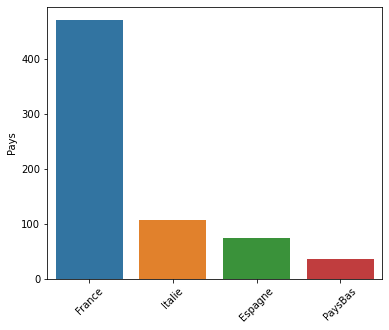

ghraph for effectifs :counts= 8


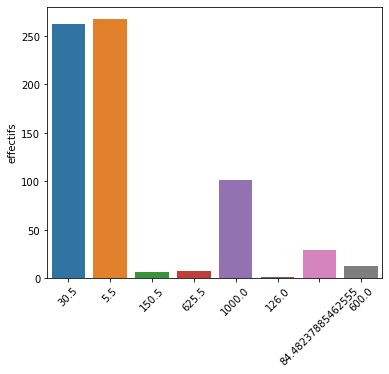

ghraph for Mois :counts= 19


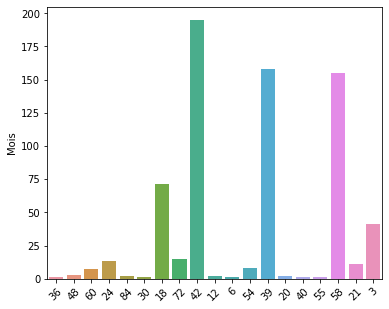

In [22]:

data =df[['Pays','effectifs','Mois']]
for i in data.columns:
    num=data[i].value_counts()
    print('ghraph for %s :counts= %d' % (i ,len(num)))
    fig, ax = plt.subplots(figsize=(6,5))
    g=sns.barplot(x=num.index,y=num)
    g.set_xticklabels(num.index,rotation=45)
    
    plt.show()

## Part 2: Modeling

In [23]:
df1=df

In [24]:
df1.head()

,Pays,Taux,Mois,Montant,Niveau_de_risque,Emprunteur,capital_social,année_de_création,Antériorité,effectifs
0,France,5.85,48,1100000.0,B,Ets Provost Frères,3058500.0,1962,1991,30.500000
1,Espagne,5.50,48,310000.0,B+,INTERNATIONAL STUDIES SA,396072.0,1985,1998,30.500000
2,PaysBas,6.45,48,165000.0,B,Docufiller Sales,900.0,2016,2016,5.500000
3,France,0.06,60,2000000.0,B,E.B.P.,10000.0,2016,2014,150.500000
4,Italie,4.90,36,100000.0,B+,Deltagamma,10000.0,2003,2003,84.482379


In [25]:
#drop Pays column

df1.drop(['Pays'],axis=1,inplace=True)


In [26]:
lbl1 = LabelEncoder()
df1['Niveau_de_risque']= lbl1.fit_transform(df1['Niveau_de_risque'])

lbl2 = LabelEncoder()
df1['Emprunteur']= lbl2.fit_transform(df1['Emprunteur'])

In [27]:
df1

,Taux,Mois,Montant,Niveau_de_risque,Emprunteur,capital_social,année_de_création,Antériorité,effectifs
0,5.85,48,1100000.0,3,190,3058500.0,1962,1991,30.500000
1,5.50,48,310000.0,5,277,396072.0,1985,1998,30.500000
2,6.45,48,165000.0,3,158,900.0,2016,2016,5.500000
3,0.06,60,2000000.0,3,166,10000.0,2016,2014,150.500000
4,4.90,36,100000.0,5,148,10000.0,2003,2003,84.482379
...,...,...,...,...,...,...,...,...,...
683,0.08,36,150000.0,7,579,3100.0,2015,2015,5.500000
684,0.07,60,1050000.0,3,223,900800.0,2007,2007,150.500000
685,9.50,60,210000.0,7,516,129215.0,1999,1999,5.500000
686,0.07,36,105000.0,3,156,727041.0,1993,1993,5.500000


In [31]:
Featuer= df1.drop('Taux',axis=1)
Y = df1.Taux.ravel()


In [32]:
st=StandardScaler()
X= st.fit_transform(Featuer)

In [33]:
X_train , X_test ,y_train, y_test= train_test_split(X,Y,test_size=0.2)


In [34]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=10, random_state=1, shuffle=True)



### Model Comparison and Selection

In [35]:
# Spot Check Algorithms
models = []
models.append(('LS', Lasso()))
models.append(('RFR', RandomForestRegressor()))
models.append(('GBR', GradientBoostingRegressor( )))
models.append(('KNN', KNeighborsRegressor()))
models.append(('DTR', DecisionTreeRegressor()))
models.append(('XGBR', XGBRegressor()))


In [36]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold= KFold(n_splits=10, random_state=1, shuffle=True)

    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LS: -7.911610 (1.104624)
RFR: -8.051932 (1.136231)
GBR: -8.429673 (1.659464)
KNN: -8.619128 (1.311057)
DTR: -15.074170 (1.980959)
XGBR: -9.972062 (1.247289)


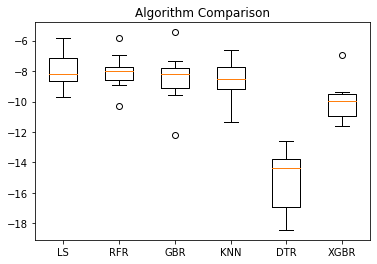

In [37]:
# Compare Algorithms
from matplotlib import pyplot

pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

### Improve Accuracy with Algorithm Tuning


In [38]:
ls =Lasso(random_state=0, max_iter=10000)
alphas = np.logspace(0.1, 1, 30)
param_grid = [{'alpha': alphas}]
grid_LS = GridSearchCV(estimator=ls, param_grid = param_grid, cv = 5, n_jobs=-1)
grid_LS.fit(X_train, y_train)
print(" Results from Grid Search " )
print("\n The best score across ALL searched params:\n",grid_LS.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_LS.best_params_)

 Results from Grid Search 

 The best score across ALL searched params:
 -0.010038457070680717

 The best parameters across ALL searched params:
 {'alpha': 1.2589254117941673}


In [39]:
gbr = GradientBoostingRegressor()
parameters = {'learning_rate': [0.001,0.01,0.02],
                  'subsample'    : [0.01,0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [50,100,500,1000, ],
                  'max_depth'    : [4,6,8,10]
                 }
grid_GBR = GridSearchCV(estimator=gbr, param_grid = parameters, cv = 5, n_jobs=-1)
grid_GBR.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.02],
                         'max_depth': [4, 6, 8, 10],
                         'n_estimators': [50, 100, 500, 1000],
                         'subsample': [0.01, 0.9, 0.5, 0.2, 0.1]})

In [41]:
print(" Results from Grid Search " )
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

 Results from Grid Search 

 The best score across ALL searched params:
 0.0157462458196286

 The best parameters across ALL searched params:
 {'learning_rate': 0.001, 'max_depth': 4, 'n_estimators': 1000, 'subsample': 0.9}


### Evaluate model

In [42]:
best_gbr= GradientBoostingRegressor(learning_rate= 0.01, max_depth= 4, n_estimators=1000, subsample=0.9)
best_gbr.fit(X_train, y_train)
pre=best_gbr.predict(X_test)

In [43]:
print("\n The best score across ALL searched params:\n",mean_absolute_error(y_test,pre))



 The best score across ALL searched params:
 2.139425203720206


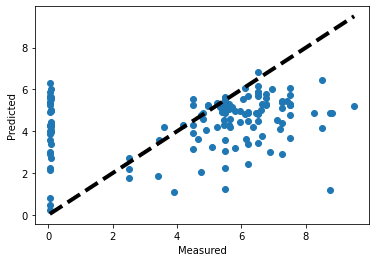

In [44]:
fig, ax = plt.subplots()
ax.scatter(y_test, pre)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

## Part 3: Alternative data

1-to improve the model we need to improve the quality and quantity of data we have, alternative data can be useful in this case such as historical account balances and payment patterns looking across checks, mortgages, auto loans and project loans, the worker's wages 

2-I often use the generative model in image data it's very effective in entering little noise on image keep features exist and reliable, in our case, it's very sensitive the data should be real-world cases to be effective, generative data may lead the predict unreal results

3-In the stock market research have been using a variety of alternative sources, social media, Twitter because of its popularity and easy accessibility,  The Wall Street Journal, Financial Times and Thomson Reuters same way can be used, in ours, this can be applicable  Most of
the aforementioned sources are mostly comprised of textual data-rich in information. In order for this type of content
to be useful for machine learning algorithms, The degree to which companies have jointly mentioned the name, the Emotions such as "hope", "fear" and "worry"  in the tweets contain the company names...